# Inference incorporating knowledge with Bert

## 1. Import libraries

In [1]:
import json
import torch
import transformers
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
import random
import numpy as np

In [2]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax

In [3]:
from scipy import stats

## 2. Model Initialization

For replicability, import the model's random weights from here [driver folder](https://drive.google.com/drive/folders/1tfITHi0PKAeDs_eDW8fqxUsl6YjhZIju?usp=sharing) and copy them to a folder in your own Drive.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
model_path = '/content/drive/My Drive/266/project/model_checkpoints' # replace with the path where you stored the imported weights

# Create the directory if it doesn't exist
if not os.path.exists(model_path):
  os.makedirs(model_path, exist_ok=True)

# If there is a model checkpoint, load it.
if not os.listdir(model_path):
  print("Creating Checkpoint...")
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1).cuda()
  model.save_pretrained(model_path)
  tokenizer.save_pretrained(model_path)
else:
  print("Reading from Checkpoint...")
  tokenizer = BertTokenizer.from_pretrained(model_path)
  model = BertForSequenceClassification.from_pretrained(model_path).cuda()

Reading from Checkpoint...


In [6]:
model.eval()  # Ensure the model is in evaluation mode

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## 3. Load dataset

We'll be using the validation set of the [ROC Cloze Dataset](https://paperswithcode.com/dataset/rocstories) as well as the dataset with embedded knowledge produced when we prompted the gpt.

In [7]:
val_path = "/content/drive/My Drive/266/project/validation_set/"

with open(val_path+"val_set.json") as f:
    ds = json.load(f)

with open(val_path+"val_set_knowledge.json") as f:
    ds_know = json.load(f)

In [8]:
ds[0]

{'InputStoryid': '138d5bfb-05cc-41e3-bf2c-fa85ebad14e2',
 'cands': ['He is happy now.', 'He joined a gang.'],
 'answer': 'He is happy now.',
 'query': "Rick grew up in a troubled household. He never found good support in family, and turned to gangs. It wasn't long before Rick got shot in a robbery. The incident caused him to turn a new leaf."}

In [9]:
ds_know[0]

{'InputStoryid': '138d5bfb-05cc-41e3-bf2c-fa85ebad14e2',
 'cands': ['He is happy now.', 'He joined a gang.'],
 'answer': 'He is happy now.',
 'query': "Rick grew up in a troubled household. He never found good support in family, and turned to gangs. It wasn't long before Rick got shot in a robbery. The incident caused him to turn a new leaf.",
 'knowledge': "Growing up in a challenging environment can impact a person's choices and lead them down negative paths such as joining gangs. Traumatic experiences like getting shot can sometimes serve as a turning point for individuals, motivating them to make positive changes in their lives."}

## 4. Inference with & without knowledge

In [10]:
def score_with_bert(tokenizer, model, story, knowledge, candidates, token_count=False, max_length=512):
  '''
  Calculate the probabilities for each candidate outcome given a sample story.
  Args:
    tokenizer: BertTokenizer
    model: BertModel
    story (str): Sample story
    knowledge (str): Sample embedded knowledge
    candidates (list): Possible outcomes of sample
    token_count (bool): Print the number of tokens in input if activated
    max_length (int): Length of the tokenized text
  Returns:
    probs (list floats): Softmax probabilities over the candidates

  '''
  scores = []
  for cand in candidates:

      # Format input text as: [CLS] context [SEP] candidate [SEP]
      story = f"{story} {knowledge}" if knowledge is not None else story
      inputs = tokenizer.encode_plus(story, cand, max_length=max_length, truncation=True, return_tensors='pt', add_special_tokens=True).to(model.device)

      if token_count:
        # Print the number of tokens for debugging purposes
        num_tokens = inputs["input_ids"].size(1)
        print(f"Number of tokens for {cand} : {num_tokens}")
        if num_tokens > max_length:
          print("Max length exceeded")

      # Forward pass, get logits
      with torch.no_grad():
          outputs = model(**inputs)
          logits = outputs.logits.squeeze().item()

      # Store the logits as scores
      scores.append(logits)

  # Convert scores to probabilities
  probs = softmax(torch.tensor(scores), dim=0)
  return probs

def predict_with_bert(story:str, candidates:list, knowledge:str, token_count=False, token_max_len=512):
  '''
  Returns the model's prediction on the given sample story.
  '''
  probs = score_with_bert(tokenizer, model, story, knowledge, candidates, token_count=token_count, max_length=token_max_len)
  prediction = candidates[probs.argmax().item()]
  return prediction, probs

In [11]:
def process_dataset(data):
  '''
  Run the model on given dataset.
  Args:
    data: dataset read from json
  Returns:
    probs_df (Pandas DataFrame): dataframe with probility for the correct and incorrect outcome
    acc (float): performance metric

  '''
  # prepare counters for metric calculation and data structures to save results
  pbar = tqdm(data)
  num, den = 0, 0
  correct_probs, incorrect_probs = [], []
  probs_df = pd.DataFrame(columns=["ID", "correct_prob", "incorrect_prob"])

  for item in pbar:

    # get item information
    story, candidates = item["query"], item["cands"]
    knowledge = item["knowledge"] if "knowledge" in item.keys() else None

    # predict
    item_prediction, item_probs = predict_with_bert(story, candidates, knowledge)

    # retrieve probabilities of outcomes
    if item_prediction == item["answer"]:
      num += 1
      correct_probs.append(item_probs.max().item())
      incorrect_probs.append(item_probs.min().item())
      probs_df.loc[len(probs_df)] = [item["InputStoryid"], item_probs.max().item(), item_probs.min().item()]
    else:
      correct_probs.append(item_probs.min().item())
      incorrect_probs.append(item_probs.max().item())
      probs_df.loc[len(probs_df)] = [item["InputStoryid"], item_probs.min().item(), item_probs.max().item()]

    # compute ongoing accuracy
    den += 1
    pbar.set_postfix({'acc': num / den})

  return probs_df, num/den

In [12]:
probs_no_know, acc_no_know = process_dataset(ds)

100%|██████████| 1571/1571 [01:14<00:00, 20.96it/s, acc=0.472]


In [13]:
probs_know, acc_know = process_dataset(ds_know)

100%|██████████| 1571/1571 [00:57<00:00, 27.13it/s, acc=0.516]


## 5. Hypothesis Test

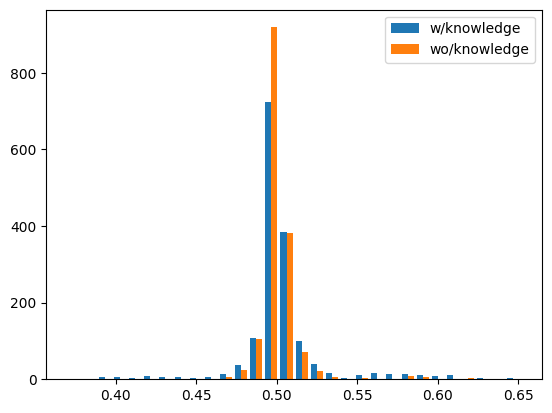

In [14]:
fig, ax = plt.subplots()
ax.hist([probs_know["correct_prob"], probs_no_know["correct_prob"]], bins=30)
ax.legend(["w/knowledge", "wo/knowledge"])
plt.show()

In [16]:
probs_know["correct_prob"].mean(), probs_know["correct_prob"].std()

(0.5034754251045152, 0.026935138549646482)

In [17]:
probs_no_know["correct_prob"].mean(), probs_no_know["correct_prob"].std()

(0.5007899779752892, 0.015181218894677476)

In [18]:
t_stat, p_val = stats.ttest_rel(probs_know["correct_prob"], probs_no_know["correct_prob"])
print("t stat", t_stat, "p value", p_val)

t stat 3.9247544536772514 p value 9.057083212215251e-05
